# MTEOR 454 (Dynamics II) Waves Project

*By: Jon Thielen*

*Modified from original scripts for preparation as a source code sample for the 2018 Unidata Summer Internship Application*

This notebook is a collection of my automated analysis procedures from the [Waves Project](http://www.meteor.iastate.edu/classes/mt454/WavesProject/Wave_analysis.html) for the [MTEOR 454](http://www.meteor.iastate.edu/classes/mt454/) (Dynamics II) class at Iowa State University, as taught by [Rachindra Mawalagedara](rmawala@iastate.edu).

The overall goal of the project was to gain insight into the nature of large-scale waves in the atmosphere, especially in regards to Rossby Wave Theory. The typical analysis procedure (as described in the above link) involved visual inspection of wave properties and wind values from plots produced using GEMPAK, a procedure that is highly prone to human error. And so, I decided it worthwhile to script the analysis both to reduce possibilities for error and to expand the possibilities of what data is available to analyze.

This notebook includes:

- Source Data Retrival
    - Basics of using the functions found in the `retrieval.py` companion script to obtain a case set of data from GFS Analyses on NCEI NOMADS
    - Or, can utilize the `sample_data.nc` file, which contains the data for the same times we looked at in our class (Sep - Nov 2017)
- Data Analysis: Obtaining the Variables for Our Study
    - Obtain the following along the 50 deg latitude north and south circles:
        - Smoothed 500 hPa heights 
        - Zonal-average zonal winds at 500 hPa and the 150-300 hPa layer maximum
        - Wave maxima/minima, and from these:
            - Wave number
            - Average wave amplitude
            - Average wave speed
            - (for this, helper functions from `wave_properties.py` are used)
- Results
    - Investigate correlations between our variables, and see how they correspond to Rossby Wave Theory
    - Make Hovmöller diagrams of our height data, to visualize wave evolution over the period

In [1]:
# Imports
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.signal import savgol_filter
from scipy.stats import linregress
from datetime import datetime, timedelta
from metpy.units import units
from metpy.constants import earth_avg_radius, earth_avg_angular_vel
from retrieval import compile_archive, retrieve_gfs_analysis
from wave_properties import get_minima_indicies, get_maxima_indicies, get_increments, reject_outliers, fraction_of_day

## Source Data Retrieval

### Option 1: Retrieve Your Own Data

In [ ]:
start = datetime(2017, 9, 1, 0, 0) # September 1, 2017
end = start + timedelta(days=5) # 5 Days later

data = compile_archive(start, end)
data

### Option 2: Use the 2017 SON Sample Data

In [2]:
data = xr.open_dataset('sample_data.nc')
start = data.time[0].values # Get initial time
data

<xarray.Dataset>
Dimensions:                       (isobaric: 8, lat: 2, lon: 360, time: 358)
Coordinates:
  * isobaric                      (isobaric) float32 15000.0 20000.0 25000.0 ...
  * lon                           (lon) float32 0.0 1.0 2.0 3.0 4.0 5.0 6.0 ...
  * lat                           (lat) float64 50.0 -50.0
  * time                          (time) datetime64[ns] 2017-09-01 ...
Data variables:
    u-component_of_wind_isobaric  (time, isobaric, lat, lon) float32 ...
    Geopotential_height_isobaric  (time, isobaric, lat, lon) float32 ...
Attributes:
    Originating_or_generating_Center:                                        ...
    Originating_or_generating_Subcenter:                                     ...
    GRIB_table_version:                                                      ...
    Type_of_generating_process:                                              ...
    Analysis_or_forecast_generating_process_identifier_defined_by_originating...
    Conventions:       

## Data Analysis

### Smoothed 500 hPa Heights

Smooth the 1-D height data with a Savitzky-Golay filter.

In [3]:
# Get the smoothed data
heights = data['Geopotential_height_isobaric'].rename('heights')
heights_smoothed = xr.DataArray(savgol_filter(heights, 39, 2, mode="wrap"), coords=heights.coords, attrs=heights.attrs, name='heights_smoothed')

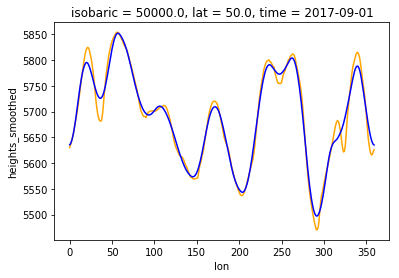

In [4]:
# Compare the raw and smoothed data at 500 hPa (using NH, initial time as example)
heights.sel(isobaric=50000., lat=50, time=start).plot(color='orange')
heights_smoothed.sel(isobaric=50000., lat=50, time=start).plot(color='blue')

### Zonal Winds

In [5]:
# Get the 500 hPa, and 150-300 hPa layer-max zonal-average zonal wind
zonal_winds = data['u-component_of_wind_isobaric'].mean(dim='lon')
zonal_wind_500 = zonal_winds.sel(isobaric=50000.)
zonal_wind_upper = zonal_winds.where(zonal_winds.isobaric <= 30000, drop=True).max(dim='isobaric')

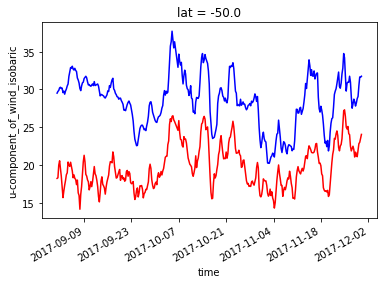

In [6]:
# Plot over time (for example, in SH)
zonal_wind_500.sel(lat=-50).plot(color='red')
zonal_wind_upper.sel(lat=-50).plot(color='blue')

### Wave Properties

In [7]:
# Variables for storage of analyzed values (lists of lists)
minima_full = [[] for lat in heights_smoothed.lat]
maxima_full = [[] for lat in heights_smoothed.lat]
wave_number_full = [[] for lat in heights_smoothed.lat]
wave_amplitude_full = [[] for lat in heights_smoothed.lat]
wave_speed_full = [[] for lat in heights_smoothed.lat]

# Loop over hemispheres and times to compute wave properties (extrema, wave number, wave amplitude, wave speed)
for j in range(0, len(heights_smoothed.lat)):
    
    lat = heights_smoothed.lat[j]
    
    # Get this particular latitude's storage variables
    minima = minima_full[j]
    maxima = maxima_full[j]
    wave_number = wave_number_full[j]
    wave_amplitude = wave_amplitude_full[j]
    wave_speed = wave_speed_full[j]

    for i in range(0, len(heights_smoothed.time)):
        this_time = heights_smoothed.time[i]
        
        # Filter out this time's height data
        current_heights = heights_smoothed.sel(isobaric=50000., lat=lat, time=this_time)
        
        # Get the minima and maxima
        minima_indicies = get_minima_indicies(current_heights)
        maxima_indicies = get_maxima_indicies(current_heights)
        minima.append(current_heights.lon[minima_indicies].values)
        maxima.append(current_heights.lon[maxima_indicies].values)
        
        # Calculate Wave Number
        k = max(len(minima_indicies), len(maxima_indicies))
        wave_number.append(k)
        
        # Calculate Amplitude
        trough_avg = current_heights[minima_indicies].values.mean()
        ridge_avg = current_heights[maxima_indicies].values.mean()
        a = (ridge_avg-trough_avg)/2.
        wave_amplitude.append(a)
        
        # Calculate Wave Speed
        if i == 0:
            # First time, cannot compute one-sided backwards difference
            c = np.nan
        else:
            # Otherwise, calculate speed (in deg lon/day)
            previous_minima = minima[i-1]
            previous_maxima = maxima[i-1]
            current_minima = minima[i]
            current_maxima = maxima[i]
            
            time_diff = heights_smoothed.time[i] - heights_smoothed.time[i-1]
            
            minima_increments = get_increments(previous_minima, current_minima)
            maxima_increments = get_increments(previous_maxima, current_maxima)
            lon_increments = np.concatenate([minima_increments, maxima_increments])
            
            c = reject_outliers(lon_increments).mean() / fraction_of_day(time_diff.values)
        
        wave_speed.append(c)
        
# Get our variables back into nice DataArrays
wave_property_coords = [('lat', heights_smoothed.lat), ('time', heights_smoothed.time)]

wave_number_raw = xr.DataArray(wave_number_full, coords=wave_property_coords, name='wave_number')
wave_amplitude = xr.DataArray(wave_amplitude_full, coords=wave_property_coords, name='wave_amplitude')
wave_speed = xr.DataArray(wave_speed_full, coords=wave_property_coords, name='wave_speed')

# Set unit metadata
wave_number_raw.attrs['units'] = 'earth_radius^-1'
wave_amplitude.attrs['units'] = 'm'
wave_speed.attrs['units'] = 'degrees_lon day^-1'

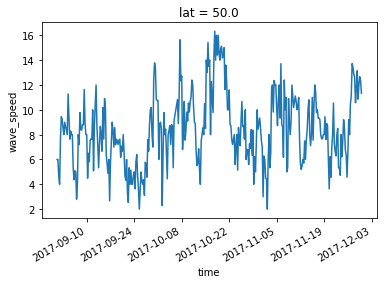

In [8]:
# Now, for example, see how the wave speed changed over time (NH)
wave_speed.sel(lat=50).plot()

## Results

For the barotropic long-waves of Rossby Wave Theory, we expect the following phase speed:

$$c_x = u - \frac{\beta}{k^2 + l^2},$$

where $u$ is background zonal flow, $\beta = \frac{\partial f}{\partial y}$, and $k$ and $l$ are zonal and meridional wave numbers, respectively. We also expect that wave patterns with higher wave numbers will have lower amplitudes. And so, below we will investigate the degree to which our observations fit our theory by looking at the following correlations:

- Wave Speed vs. Zonal Wind
- Wave Speed vs. Wave Number
- Wave Amplitude vs. Wave Number

### Correlations

*Unit Conversions*

- Convert `wave_number` from earth_radius<sup>-1</sup> to m<sup>-1</sup>
- Convert `wave_speed` from deg_lon day<sup>-1</sup> to m s<sup>-1</sup>

In [9]:
lat = 50 * units('degrees')

# Wave number conversion factor
scale_factor = 1 / earth_avg_radius
wave_number = wave_number_raw * scale_factor
wave_number.attrs['units'] = 'm^-1'

# Wave speed conversion factor
scale_factor = (units('degrees day^-1') * 2 * np.pi * np.cos(lat) * earth_avg_radius / (360 * units('degrees'))).to('m s^-1')
# Make sure this runs only once
if wave_speed.attrs['units'] == 'degrees_lon day^-1':
    wave_speed = wave_speed * scale_factor
    wave_speed.attrs['units'] = 'm s^-1'

**Wave Speed vs. Zonal Wind**

Here, we would expect to see a roughly linear relationship, with slope near 1, but variability in the y-intercept due to the (presently unaccounted for) wave number.

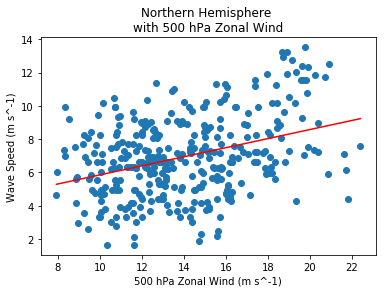

Slope: 0.2725805009176642
Correlation: 0.35785164525742


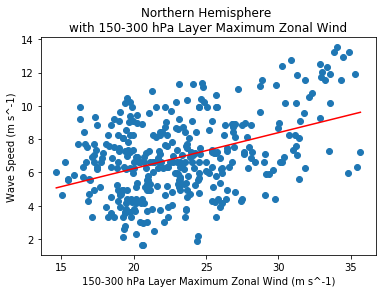

Slope: 0.21628434662131768
Correlation: 0.4201702457396746


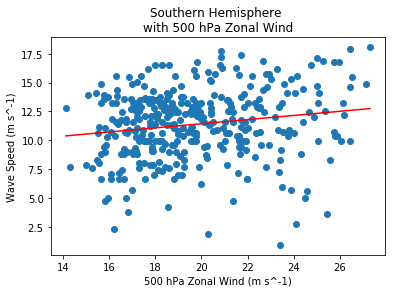

Slope: 0.17921777087213803
Correlation: 0.17028957017848562


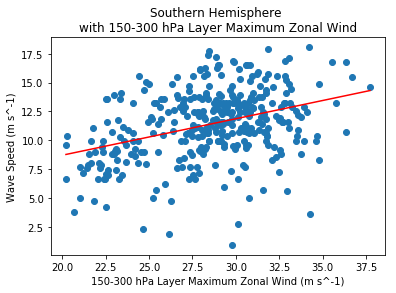

Slope: 0.3165780926628395
Correlation: 0.3691727290405078


In [10]:
# Define four different subsets of our data to consider
configs = [
    {
        'hemisphere': 1,
        'hemisphere_label': 'Northern Hemisphere',
        'wind': zonal_wind_500,
        'wind_label': '500 hPa Zonal Wind'
    },
    {
        'hemisphere': 1,
        'hemisphere_label': 'Northern Hemisphere',
        'wind': zonal_wind_upper,
        'wind_label': '150-300 hPa Layer Maximum Zonal Wind'
    },
    {
        'hemisphere': -1,
        'hemisphere_label': 'Southern Hemisphere',
        'wind': zonal_wind_500,
        'wind_label': '500 hPa Zonal Wind'
    },
    {
        'hemisphere': -1,
        'hemisphere_label': 'Southern Hemisphere',
        'wind': zonal_wind_upper,
        'wind_label': '150-300 hPa Layer Maximum Zonal Wind'
    } 
]

# Loop over the configurations
for config in configs:
    # Mask the initial NaN, and calculate linear regression
    y = np.ma.masked_invalid(wave_speed.sel(lat=config['hemisphere'] * 50).values)
    x = np.ma.masked_where(np.ma.getmask(y), config['wind'].sel(lat=config['hemisphere'] * 50).values) 
    m, b, r, p, stderr = linregress(x.compressed(), y.compressed())

    # Set up plot
    ax = plt.subplot()
    ax.set_title('{} \nwith {}'.format(config['hemisphere_label'], config['wind_label']))
    ax.set_ylabel('Wave Speed (m s^-1)')
    ax.set_xlabel('{} (m s^-1)'.format(config['wind_label']))

    # Scatter Plot
    ax.scatter(x, y)

    # Regression Line
    xfill = np.array([x.min(), x.max()])
    ax.plot(xfill, m * xfill + b, color='red')

    plt.show()
    print("Slope: {}".format(m))
    print("Correlation: {}".format(r))

**Wave Speed vs. Wave Number**

Here, we first have to normalize our wave speed and wave number in order to obtain a theoretical linear relationship:

$$c_x - u = (-\beta) \frac{1}{k^2},$$

(Note that this also ignores meridional wave number, since we are primarily concerned with the zonal waves.) And so, we would expect to see a linear relationship, with slope near $-\beta$, and a y-intercept near zero.

In [11]:
# Find beta (same in NH and SH due to symmetry)
beta = (2 * earth_avg_angular_vel * np.cos(lat) / earth_avg_radius).to('m^-1 s^-1')
beta

<Quantity(1.471396823264012e-11, '1 / meter / second')>

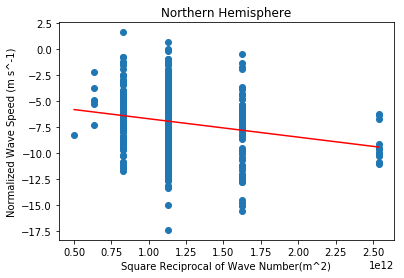

Slope: -1.7709084968717028e-12
Correlation: -0.20761990378298603


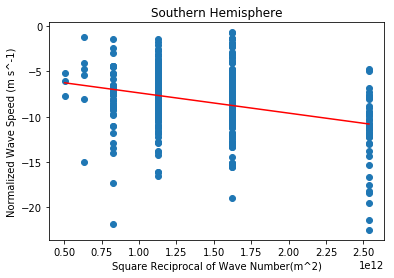

Slope: -2.2322593497274885e-12
Correlation: -0.3014444451549039


In [12]:
# Prepare our variables
normalized_wave_speed = wave_speed - zonal_wind_500
linearized_wave_number = 1 / wave_number ** 2

# Define two different subsets of our data to consider
configs = [
    {
        'hemisphere': 1,
        'hemisphere_label': 'Northern Hemisphere'
    },
    {
        'hemisphere': -1,
        'hemisphere_label': 'Southern Hemisphere'
    }
]

# Loop over the configurations
for config in configs:
    # Mask the initial NaN, and calculate linear regression
    y = np.ma.masked_invalid(normalized_wave_speed.sel(lat=config['hemisphere'] * 50).values)
    x = np.ma.masked_where(np.ma.getmask(y), linearized_wave_number.sel(lat=config['hemisphere'] * 50).values) 
    m, b, r, p, stderr = linregress(x.compressed(), y.compressed())

    # Set up plot
    ax = plt.subplot()
    ax.set_title(config['hemisphere_label'])
    ax.set_ylabel('Normalized Wave Speed (m s^-1)')
    ax.set_xlabel('Square Reciprocal of Wave Number(m^2)')

    # Scatter Plot
    ax.scatter(x, y)

    # Regression Line
    xfill = np.array([x.min(), x.max()])
    ax.plot(xfill, m * xfill + b, color='red')

    plt.show()
    print("Slope: {}".format(m))
    print("Correlation: {}".format(r))

**Wave Amplitude vs. Wave Number**

This is a resonably straightforward relationship: we expect the wave amplitude to decrease as wave number increases.

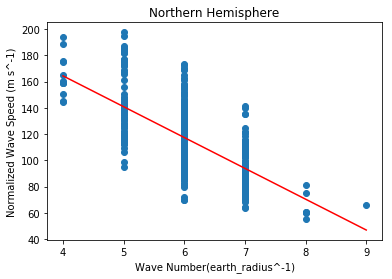

Slope: -23.473493074344614
Correlation: -0.65064530853795


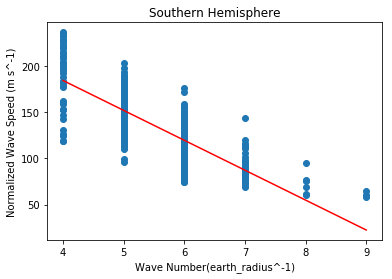

Slope: -32.38261268942799
Correlation: -0.7842735725902317


In [13]:
# Define two different subsets of our data to consider
configs = [
    {
        'hemisphere': 1,
        'hemisphere_label': 'Northern Hemisphere'
    },
    {
        'hemisphere': -1,
        'hemisphere_label': 'Southern Hemisphere'
    }
]

# Loop over the configurations
for config in configs:
    # Mask the initial NaN, and calculate linear regression
    y = wave_amplitude.sel(lat=config['hemisphere'] * 50).values
    x = wave_number_raw.sel(lat=config['hemisphere'] * 50).values
    m, b, r, p, stderr = linregress(x, y)

    # Set up plot
    ax = plt.subplot()
    ax.set_title(config['hemisphere_label'])
    ax.set_ylabel('Normalized Wave Speed (m s^-1)')
    ax.set_xlabel('Wave Number(earth_radius^-1)')

    # Scatter Plot
    ax.scatter(x, y)

    # Regression Line
    xfill = np.array([x.min(), x.max()])
    ax.plot(xfill, m * xfill + b, color='red')

    plt.show()
    print("Slope: {}".format(m))
    print("Correlation: {}".format(r))

**Conclusions**

What we found in our analysis (at least for our 2017 SON case set) was that most (but not all) of the trends expected by Rossby Wave Theory were observed in our data, but the regression statistics did not usually fit with their theoretical values. This mismatch indicates the limitations in our simplified barotropic theory when trying to apply it to the real atmosphere in the mid-latitudes, which is often baroclinic.

(For full discussion of our groups' results, and comparison of the automated method I scripted with the standard manual method, see [our report](mteor454_2017_group4_waves_report.pdf).)

### Hovmöller Diagrams

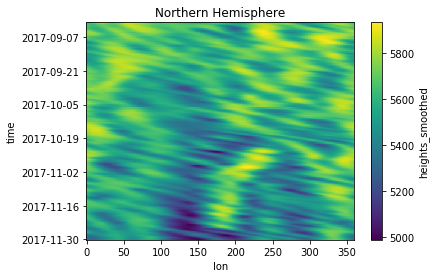

In [14]:
# Northern Hemisphere
heights_smoothed.sel(isobaric=50000., lat=50).plot(yincrease=False)
plt.title('Northern Hemisphere')
plt.show()

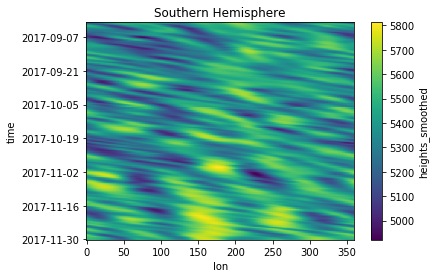

In [15]:
# Southern Hemisphere
heights_smoothed.sel(isobaric=50000., lat=-50).plot(yincrease=False)
plt.title('Southern Hemisphere')
plt.show()